### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Friday, Mar 5th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

## 1)
Read in hw4_data_1.npy. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

In [167]:
#IMPORTS
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from astroML import stats as astroMLstats
from scipy.stats import laplace

import corner

In [168]:
filename = '../../homeworks/hw_data/hw4_data_1.npy' 

data = np.load(filename)
volt_meas = data[:,0]
volt_uncert  = data[:,1]

From Lecture 5: 
$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with uncertainty
$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$


In [169]:
sample_mean = np.sum(volt_meas/volt_uncert**2)/np.sum(1/volt_uncert**2)
std_error_mean = 1/np.sqrt(np.sum(1/(volt_uncert**2)))

print('The sample mean is : {:.2f}'.format(sample_mean))
print('The standard error of the sample mean is : {:.2f}'.format(std_error_mean))


The sample mean is : 4.94
The standard error of the sample mean is : 0.43


## 2) 
Fit the appropriate ln-likelihood function and find the best-fit mean voltage.


$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$

In [170]:
def lnL_func(mu, x, sigma):
    return np.sum((x - mu)**2 / (2 * sigma**2))

f_lnL = lambda beta: lnL_func(beta, volt_meas, volt_uncert)

beta0 = 5.0
mu_fit = optimize.fmin(f_lnL, beta0)[0]
print('Best fit mean = {:.2f}' .format(mu_fit))

Optimization terminated successfully.
         Current function value: 2.807251
         Iterations: 13
         Function evaluations: 26
Best fit mean = 4.94


## 3)
Compute and plot the Bayesian posterior probability density (not the log posterior) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

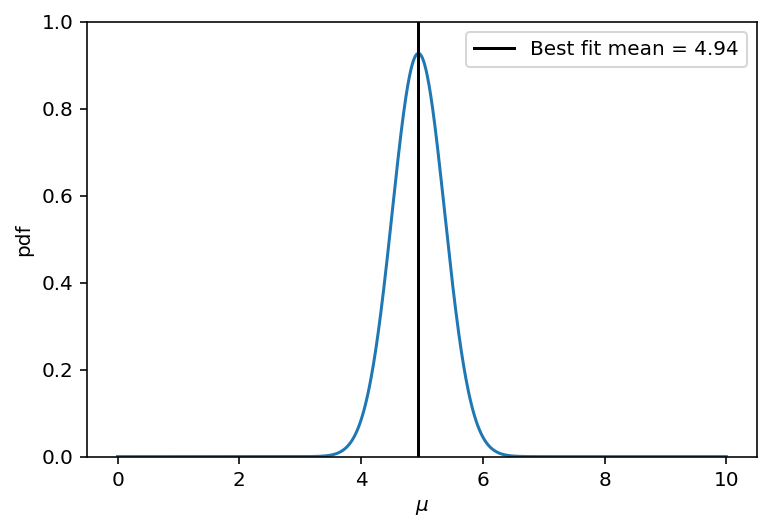

In [171]:
from scipy.stats import norm


mean_range = np.arange(3,8)
xgrid = np.linspace(0,10,1000)
#print(xgrid)

def prior(x):
    uniform = np.array([])
    for index in range(len(x)):
        if (x[index] > 3) & (x[index] < 7):
            u = 1/(7-3)
        else:
            u =  0
        uniform = np.append(uniform, u)
    return uniform 

prior2 = prior(xgrid)
##print(prior2)


#gauss_dist = norm(loc = volt_meas, scale = std_error_mean)

likelihoods = np.array([])
for ii in range(len(xgrid)):
    mu = xgrid[ii]
    L = norm.pdf(volt_meas, mu, volt_uncert)
    L = np.prod(L)
    likelihoods= np.append(likelihoods, L)
##print(likelihoods)


#Posterior = Likelihood x prior 
posterior = likelihoods * prior2
#print('posterior : ')
#print(posterior)

#Normalizing the posterior pdf 
dx = 10/1000
area = np.trapz(posterior, xgrid, dx)
#print('area')
##print(area)

posterior_normalized = posterior/area
#print(posterior_normalized)

plt.plot(xgrid,posterior_normalized)
plt.axvline(mu_fit, color = 'k' , label = 'Best fit mean = {:.2f}' .format(mu_fit))
plt.ylim(0,1)
plt.xlabel(r'$\mu$')
plt.ylabel('pdf')
plt.legend(loc='upper right')

#np.where(posterior_normalized == posterior_normalized.max())
#xgrid[np.where(posterior_normalized == posterior_normalized.max())]


## 4)
By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. Also find the MAP value of the mean.

In [172]:
dx2 = xgrid[1] - xgrid[0]
post_cdf = np.cumsum(posterior_normalized)*dx2

percent_tail = (1-.683)/2
low_tail = xgrid[post_cdf < percent_tail][-1]
high_tail = xgrid[post_cdf > (1-percent_tail)][0]
print('The 68.3% credible region is : {:.2f}' .format(low_tail) + ' < mu < {:.2f}'.format(high_tail))
#print('High tail mu = {:.2f}' .format(high_tail))


print('The sample mean - standard deviation is  : {:.2f}'.format(sample_mean-std_error_mean))
print('The sample mean + standard deviation is  : {:.2f}'.format(sample_mean+std_error_mean))

MAP = xgrid[np.argmax(posterior_normalized)]
print('MAP value of mean = {:.2f}'.format(MAP))


The 68.3% credible region is : 4.50 < mu < 5.38
The sample mean - standard deviation is  : 4.51
The sample mean + standard deviation is  : 5.37
MAP value of mean = 4.94


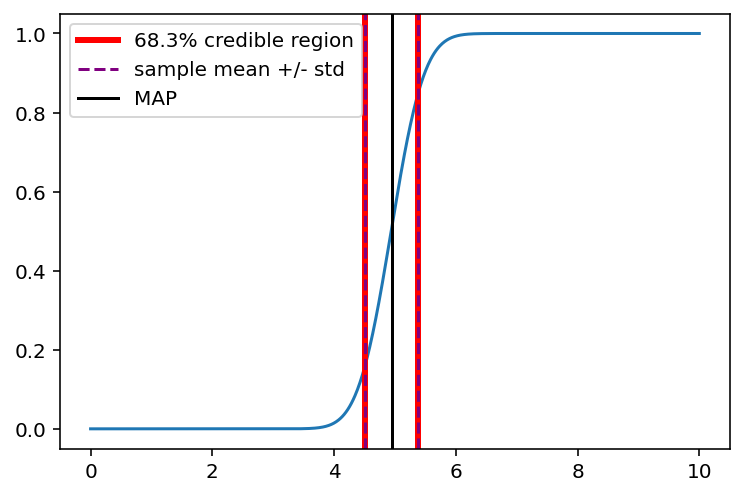

In [193]:
plt.plot(xgrid, post_cdf)
plt.axvline(low_tail, color = 'r', lw =3, label =  '68.3% credible region')
plt.axvline(high_tail, color = 'r', lw=3)

plt.axvline((sample_mean+std_error_mean), color = 'purple', ls = '--', label =  'sample mean +/- std')
plt.axvline((sample_mean-std_error_mean), color = 'purple', ls='--')

plt.axvline(MAP, color = 'k', label =  'MAP')
plt.legend(loc='upper left')

## 5) 
Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4.

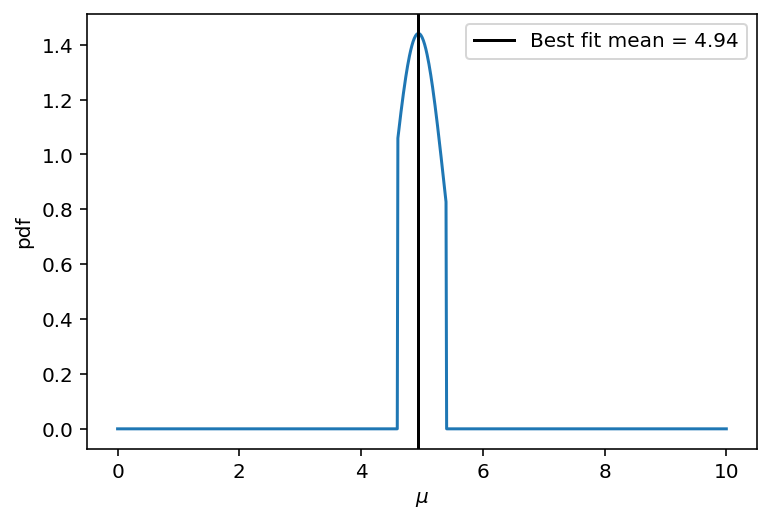

In [174]:
def prior_new(x):
    uniform = np.array([])
    for index in range(len(x)):
        if (x[index] > 4.6) & (x[index] < 5.4):
            u = 1/(5.4-4.6)
        else:
            u =  0
        uniform = np.append(uniform, u)
    return uniform 

prior3 = prior_new(xgrid)
##print(prior2)

likelihoods2 = np.array([])
for ii in range(len(xgrid)):
    mu = xgrid[ii]
    L2 = norm.pdf(volt_meas, mu, volt_uncert)
    L2 = np.prod(L2)
    likelihoods2= np.append(likelihoods2, L2)
##print(likelihoods)

posterior2 = likelihoods2*prior3

#Normalizing the posterior pdf 
dx = 10/1000
area2 = np.trapz(posterior2, xgrid, dx)
#print('area')
##print(area)

posterior_normalized2 = posterior2/area2
plt.plot(xgrid,posterior_normalized2)
plt.axvline(mu_fit, color = 'k' , label = 'Best fit mean = {:.2f}' .format(mu_fit))
plt.xlabel(r'$\mu$')
plt.ylabel('pdf')
plt.legend(loc='upper right')


In [175]:
dx2 = xgrid[1] - xgrid[0]
post_cdf2 = np.cumsum(posterior_normalized2)*dx2

percent_tail = (1-.683)/2
low_tail2 = xgrid[post_cdf2 < percent_tail][-1]
high_tail2 = xgrid[post_cdf2 > (1-percent_tail)][0]
print('The 68.3% credible region is : {:.2f}' .format(low_tail2) + ' < mu < {:.2f}'.format(high_tail2))
#print('High tail mu = {:.2f}' .format(high_tail))


print('The sample mean - standard deviation is  : {:.2f}'.format(sample_mean-std_error_mean))
print('The sample mean + standard deviation is  : {:.2f}'.format(sample_mean+std_error_mean))

MAP2 = xgrid[np.argmax(posterior_normalized2)]
print('MAP value of mean = {:.2f}'.format(MAP2))


The 68.3% credible region is : 4.72 < mu < 5.24
The sample mean - standard deviation is  : 4.51
The sample mean + standard deviation is  : 5.37
MAP value of mean = 4.94


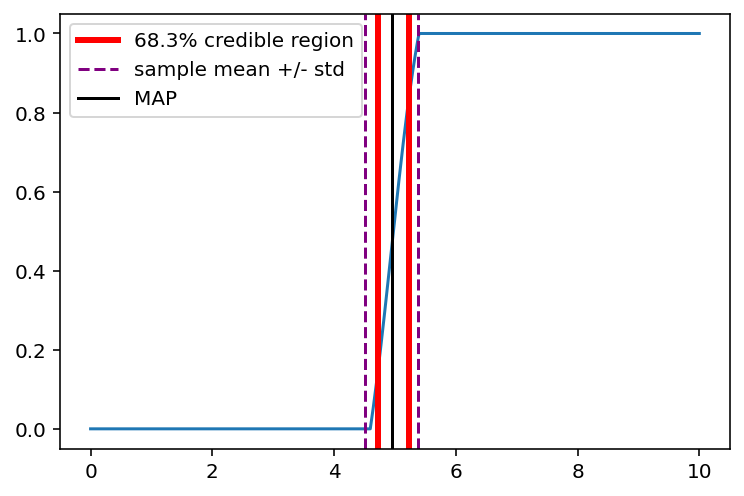

In [194]:
plt.plot(xgrid, post_cdf2)
plt.axvline(low_tail2, color = 'r', lw =3, label =  '68.3% credible region')
plt.axvline(high_tail2, color = 'r', lw=3)

plt.axvline((sample_mean+std_error_mean), color = 'purple', ls = '--', label =  'sample mean +/- std')
plt.axvline((sample_mean-std_error_mean), color = 'purple', ls='--')

plt.axvline(MAP2, color = 'k', label =  'MAP')
plt.legend(loc='upper left')

## 6)
Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually  6±0.3 . Repeat (3) and (4) this time with a Gaussian prior on the mean centered at  6  with standard deviation of  0.3 .



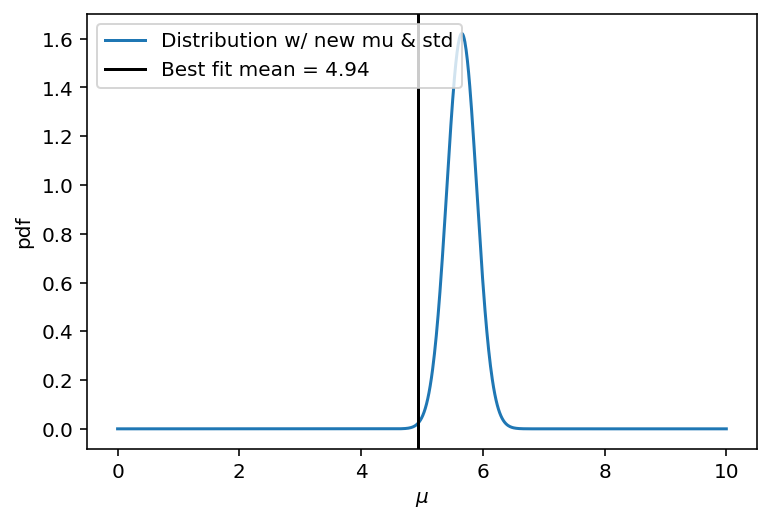

In [177]:
new_mu = 6
new_std = 0.3 

gauss_prior = norm.pdf(xgrid,loc=6,scale=0.3)


likelihoods3 = np.array([])
for ii in range(len(xgrid)):
    mu = xgrid[ii]
    L3 = norm.pdf(volt_meas, mu, volt_uncert)
    L3 = np.prod(L3)
    likelihoods3= np.append(likelihoods3, L3)
##print(likelihoods)

posterior3 = likelihoods3*gauss_prior

#Normalizing the posterior pdf 
dx = 10/1000
area3 = np.trapz(posterior3, xgrid, dx)
#print('area')
##print(area)

posterior_normalized3 = posterior3/area3
plt.plot(xgrid,posterior_normalized3, label = 'Distribution w/ new mu & std')
plt.axvline(mu_fit, color = 'k' , label = 'Best fit mean = {:.2f}' .format(mu_fit))
plt.xlabel(r'$\mu$')
plt.ylabel('pdf')
plt.legend(loc='upper left')



In [178]:
dx3 = xgrid[1] - xgrid[0]
post_cdf3 = np.cumsum(posterior_normalized3)*dx3

percent_tail = (1-.683)/2
low_tail3 = xgrid[post_cdf3 < percent_tail][-1]
high_tail3 = xgrid[post_cdf3 > (1-percent_tail)][0]
print('The 68.3% credible region is : {:.2f}' .format(low_tail3) + ' < mu < {:.2f}'.format(high_tail3))
#print('High tail mu = {:.2f}' .format(high_tail))


print('The sample mean - standard deviation is  : {:.2f}'.format(sample_mean-std_error_mean))
print('The sample mean + standard deviation is  : {:.2f}'.format(sample_mean+std_error_mean))

MAP3 = xgrid[np.argmax(posterior_normalized3)]
print('MAP value of mean = {:.2f}'.format(MAP3))


The 68.3% credible region is : 5.40 < mu < 5.90
The sample mean - standard deviation is  : 4.51
The sample mean + standard deviation is  : 5.37
MAP value of mean = 5.66


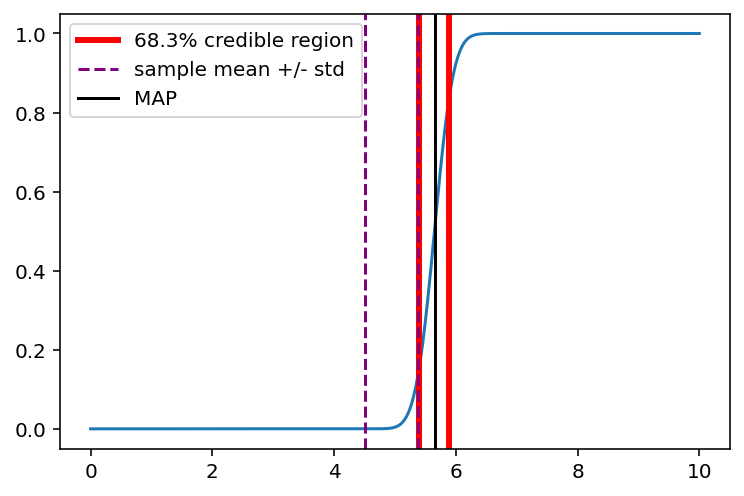

In [195]:
plt.plot(xgrid, post_cdf3)
plt.axvline(low_tail3, color = 'r', lw =3, label =  '68.3% credible region')
plt.axvline(high_tail3, color = 'r', lw=3)

plt.axvline((sample_mean+std_error_mean), color = 'purple', ls = '--', label =  'sample mean +/- std')
plt.axvline((sample_mean-std_error_mean), color = 'purple', ls='--')

plt.axvline(MAP3, color = 'k', label =  'MAP')
plt.legend(loc='upper left')

## 7)
Plot all of the normalized posterior pdfs for  𝜇  from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.



(0.0, 10.0)

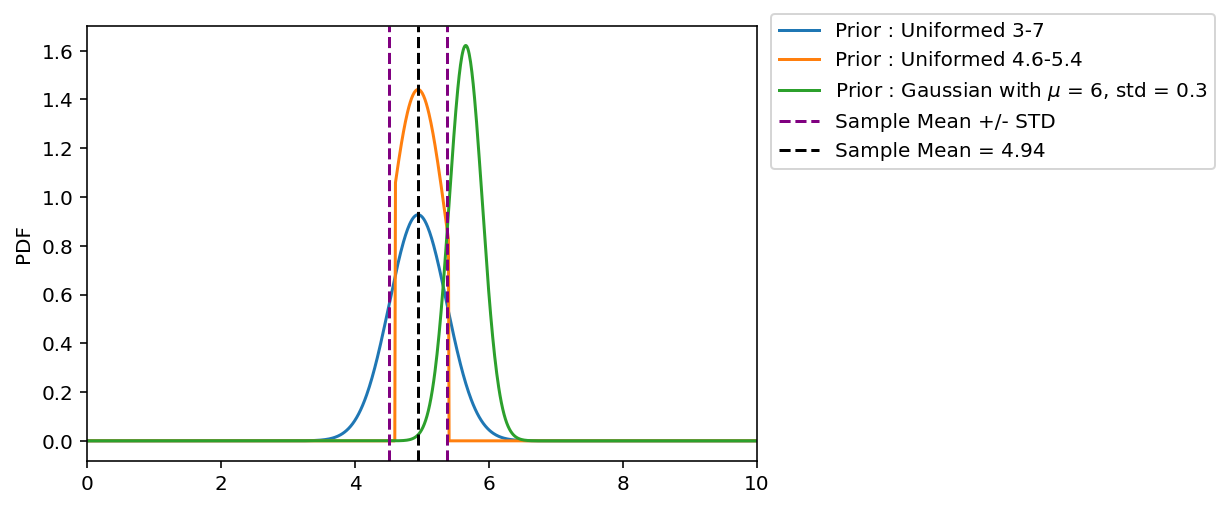

In [196]:
#Normalized posterior pdfs

plt.plot(xgrid,posterior_normalized, label = 'Prior : Uniformed 3-7')
plt.plot(xgrid,posterior_normalized2, label = 'Prior : Uniformed 4.6-5.4')
plt.plot(xgrid,posterior_normalized3, label = 'Prior : Gaussian with $\mu$ = 6, std = 0.3')
plt.axvline((sample_mean+std_error_mean), color = 'purple', ls = '--', label =  'Sample Mean +/- STD')
plt.axvline((sample_mean-std_error_mean), color = 'purple', ls='--')
plt.axvline((sample_mean), color = 'k', ls='--', label = 'Sample Mean = {:.2f}'.format(sample_mean))

plt.ylabel('PDF')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.05))
plt.xlim([0,10])

(0.0, 10.0)

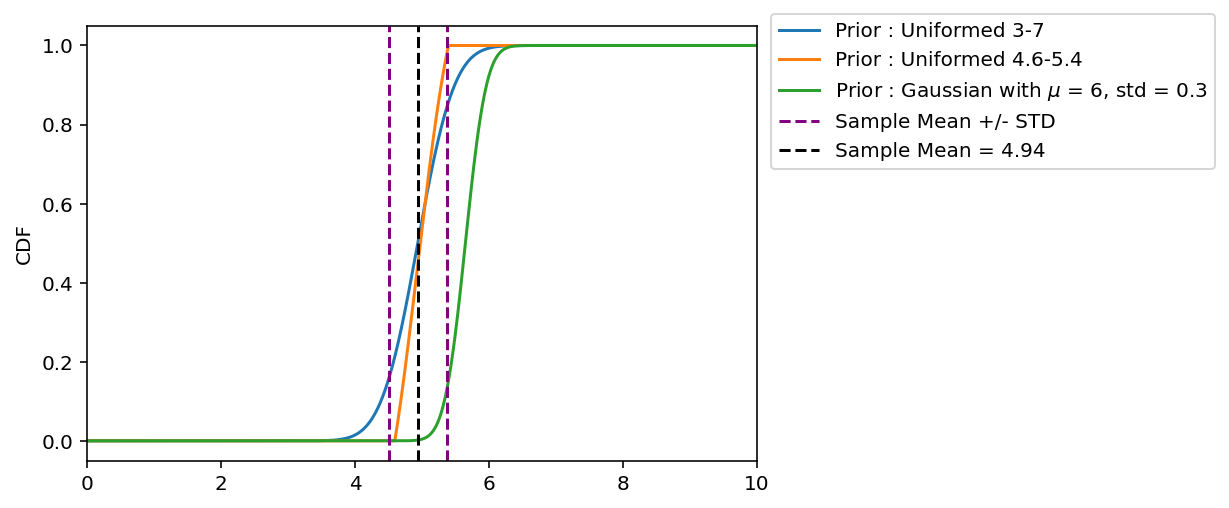

In [197]:
#CDFs

plt.plot(xgrid, post_cdf, label = 'Prior : Uniformed 3-7')
plt.plot(xgrid, post_cdf2, label = 'Prior : Uniformed 4.6-5.4')
plt.plot(xgrid, post_cdf3, label = 'Prior : Gaussian with $\mu$ = 6, std = 0.3')
plt.axvline((sample_mean+std_error_mean), color = 'purple', ls = '--', label =  'Sample Mean +/- STD')
plt.axvline((sample_mean-std_error_mean), color = 'purple', ls='--')
plt.axvline((sample_mean), color = 'k', ls='--', label = 'Sample Mean = {:.2f}'.format(sample_mean))

plt.ylabel('CDF')
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 1.05))
plt.xlim([0,10])

## 8)
You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) (think about this and don't just immediately go looking for a scipy.stats delta function). Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?

In [182]:
#Prior > delta function @ best_fit
#when integrating a function times a delta function you get the function beck > 
# int g(x)delta(x-a) dx = g(a)
factor = 0.1 
def prior_delta(x):
    delta = np.array([])
    for index in range(len(x)):
        if (x[index] > (sample_mean - factor)) & (x[index] < (sample_mean + factor)):
            d = 1/ ((sample_mean + factor) - (sample_mean - factor) )
        else:
            d =  0
        delta = np.append(delta, d)
    return delta

delta_pr = prior_delta(xgrid)

In [183]:
likelihoods4 = np.array([])
for ii in range(len(xgrid)):
    mu = xgrid[ii]
    L4 = norm.pdf(volt_meas, mu, volt_uncert)
    L4 = np.prod(L4)
    likelihoods4= np.append(likelihoods4, L4)
##print(likelihoods)

posterior4 = likelihoods4*delta_pr
#print(posterior4)
dx = 10/10000
area4 = np.trapz(posterior4, xgrid, dx)

#Evidence in (3) / Evidence (delta fn)
B_factor = area/area4

print('Bayesian factor is {:.2e}'.format(area4))
print('Since the ratio is less than one, it is inconclusive.\n The delta function seems unfavored compared to the uniform distribution ')

Bayesian factor is 1.06e-07
Since the ratio is less than one, it is inconclusive.
 The delta function seems unfavored compared to the uniform distribution 


In [184]:
#plt.plot(xgrid,delta_pr)

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [185]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

## 1)
Read in hw4_data_2.npy, which is a (3 x 20) numpy array that you used in Lecture_9. Set x, y, sigma_y = data.

In [186]:
import scipy 

filename2 = '../../homeworks/hw_data/hw4_data_2.npy'
data2 = np.load(filename2)
x, y, sigma_y = data2
y_int = -0.23

## 2) 
Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the  𝑦 -intercept is fixed. I advise a grid size of 100.

/Users/csuarez/opt/anaconda3/envs/sun2/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, 'Posterior PDF')

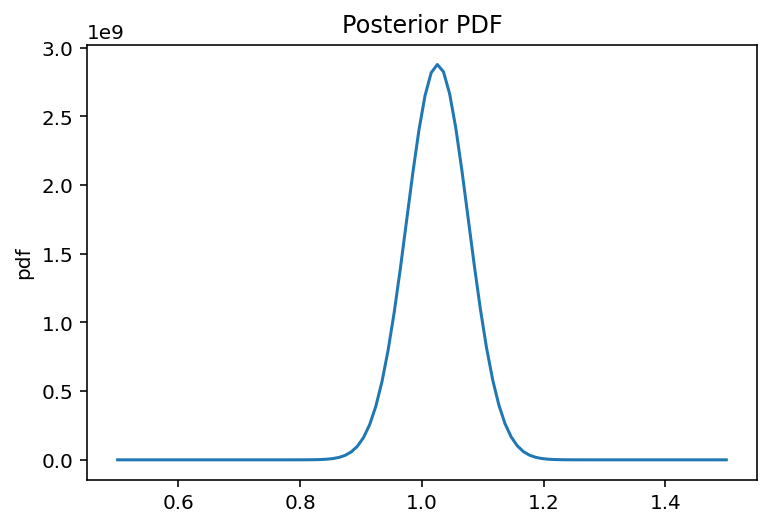

In [187]:
xgrid_2 = np.linspace(0.5, 1.5, 100)
dx_new = xgrid_2[1] - xgrid[0]

log_L_array = np.array([logL([y_int,index],data2) for index in xgrid_2])

def prior_prob2(x):
    uniform = np.array([])
    for index in range(len(x)):
        if (x[index] > 0.5) & (x[index] < 1.5):
            u = 1/(1.5-0.5)
        else:
            u =  0
        uniform = np.append(uniform, u)
    return uniform 


prior_exp2 = prior_prob2(xgrid_2)

log_prior_2 = np.log(prior_exp2)

log_posterior = log_prior_2 + log_L_array

posterior_p2 = np.exp(log_posterior)

plt.plot(xgrid_2, posterior_p2)
plt.ylabel('pdf')
plt.title('Posterior PDF')


## 3)
Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!



In [188]:
linear_model = np.trapz(posterior_p2, xgrid_2, dx_new)

print('Bayesian Evidence of model is : {:.2f}'.format(linear_model))

Bayesian Evidence of model is : 365684733.16


## 4)
Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the  𝑦 -intercept is fixed. I advise a grid size of 100 in each model dimension.


In [189]:
xgrid_new_3 = np.linspace(-1,0.25,100)
dx_new2 = xgrid_new_3[1] - xgrid_new_3[0]
log_L_array_2 = np.array([[logL([y_int,index2, index3],data2) for index2 in xgrid_2] for index3 in  xgrid_new_3])


Text(0, 0.5, 'x2 coefficient')

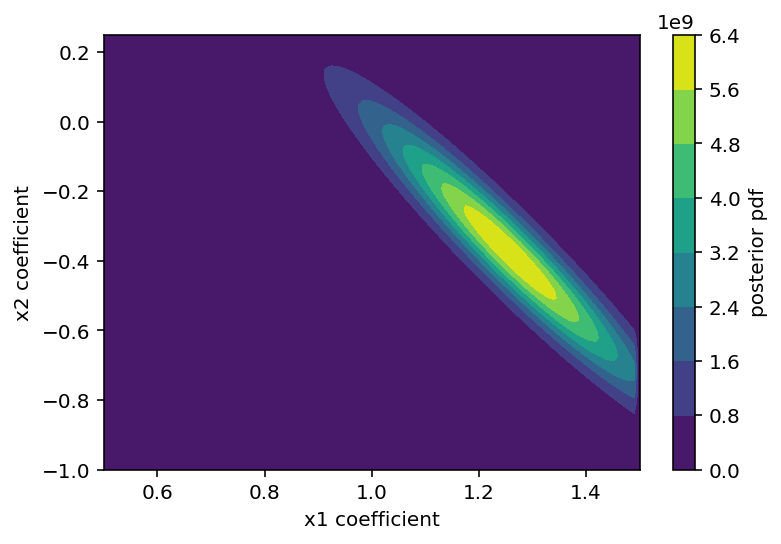

In [190]:
#Priors
def prior_prob2_1d(x):
    uniform = np.array([])
    for index in range(len(x)):
        if (x[index] > 0.5) & (x[index] < 1.5):
            u = 1/(1.5-0.5)
        else:
            u =  0
        uniform = np.append(uniform, u)
    return uniform 

def prior_prob2_2d(x):
    uniform = np.array([])
    for index in range(len(x)):
        if (x[index] > -1) & (x[index] < 0.25):
            u = 1/(0.25-(-1))
        else:
            u =  0
        uniform = np.append(uniform, u)
    return uniform 

prior_prob2_1d_2 = prior_prob2_1d(xgrid_2)
prior_prob2_2d_2 = prior_prob2_2d(xgrid_new_3)

#Posterior 
posterior_2d = np.exp(log_L_array_2) * (prior_prob2_2d_2 )
contour = plt.contourf(xgrid_2,xgrid_new_3,posterior_2d)
plt.colorbar(contour, label = 'posterior pdf')
plt.xlabel('x1 coefficient')
plt.ylabel('x2 coefficient')

## 5)

Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model.



In [191]:
#Take the double integral for 2D evidence 

d2_evidence = np.trapz(np.trapz(posterior_2d, xgrid_2, dx_new), xgrid_new_3, dx_new2)
print('Bayesian evidence for quadratic model {:.2f}'.format(d2_evidence))



Bayesian evidence for quadratic model 488111076.92


## 6)
Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture?

In [192]:
# to compare linear model vs quadratic take ratios of evidence 

ratio_evid = d2_evidence/ linear_model
print(ratio_evid)

1.3347865870794213


The Bayes factor/ratio is close to 1 so it has negative strength for evidence. The ratio compares the models, and therefore its inconcluseive how well the different models fit the data. It can also be complex to compute especially with more parameters. The BIC, seems simpler as it is calculating the chi squared plus the k (number of parameters) ln(N(number of samples)). 

$${\rm BIC} = \chi^2 + k \ln N,$$ 


$$ E(M) \equiv p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$
